# Collecter des données OpenAlex

## Découvrir l'API

Jeter un coup d'oeil ici : https://docs.openalex.org/how-to-use-the-api/api-overview

In [8]:
import yaml
with open('creds.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

https://openalex.org/works?page=1&filter=title_and_abstract.search:%22computational+social+science%22

In [9]:
import requests

url = "https://api.openalex.org/works"

headers = {
    "Authorization": f"Bearer {config['token-openalex']}"
}

params = {
    "q": "computational social science",
    "per-page": 25,
    "page": 1,
}

r = requests.get(url, headers=headers, params=params)
r.raise_for_status()
data = r.json()
#print(data["results"])


In [7]:
# data["results"][0]

Regarder l'abstract

https://docs.openalex.org/api-entities/works/work-object

Get all the data

In [10]:
import requests
import time


keyword1 = "computational social science"
keyword2 = "science sociale computationnelle"

per_page = 25     
max_results = None 

url = "https://api.openalex.org/works"

headers = {
    "Authorization": f"Bearer {config['token-openalex']}"
}

cursor = "*"
all_works = []
n = 0

while True:
    params = {
        "filter": f'title_and_abstract.search:"{keyword1}"|"{keyword2}"',
        "per-page": per_page,
        "select": "id,title,abstract_inverted_index,publication_year,type",
        "cursor": cursor
    }

    r = requests.get(url, headers=headers, params=params)
    r.raise_for_status()
    data = r.json()

    results = data.get("results", [])
    total = data["meta"]["count"]

    if not results:
        break

    all_works.extend(results)
    n += len(results)

    print(f"Fetched {n} / {total} (cursor={cursor})")

    if max_results is not None and n >= max_results:
        break

    cursor = data["meta"].get("next_cursor")
    if not cursor:
        break

    time.sleep(0.2)

print(f"\nDone. Collected {len(all_works)} works total.\n")


Fetched 25 / 1988 (cursor=*)
Fetched 50 / 1988 (cursor=IlsxOTMuMDI4OTksIDE2MDMyMzg0MDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMzA5NDQyMzA2OCddIg==)
Fetched 75 / 1988 (cursor=IlsxMjguNTQyOTcsIDE0MDUwMzY4MDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMjI0MTc1Mjc1OSddIg==)
Fetched 100 / 1988 (cursor=IlsxMDEuNjU4NCwgMTU1NTM3MjgwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1cyOTM1OTg5MDgyJ10i)
Fetched 125 / 1988 (cursor=Ils4Mi45MDAyNCwgMTQ3NDkzNDQwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1czMjE3MzM0NDg0J10i)
Fetched 150 / 1988 (cursor=Ils2OC4wMTIwMiwgMTU3NzgzNjgwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1c0MjMzOTkzNjI2J10i)
Fetched 175 / 1988 (cursor=Ils1OC40NTE5MjcsIDE1Nzc4MzY4MDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMzAyMzYyNTY2MSddIg==)
Fetched 200 / 1988 (cursor=Ils1Mi4yNTQ1MjQsIDE2MDk0NTkyMDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMzEyMTk5NzAyMCddIg==)
Fetched 225 / 1988 (cursor=Ils0NS43ODM0MSwgMTcwMjMzOTIwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1c0Mzg5NjE3Mjc4J10i)
Fetched 250 / 1988 (cursor=Ils0Mi4zNTU5MjMsIDE2MzY1MD

In [14]:
import pickle
import os

os.makedirs("data", exist_ok=True)

with open("data/all_works.pkl", "wb") as f:
    pickle.dump(all_works, f)

## Existence de wrapper

Par exemple : pyalex : https://github.com/J535D165/pyalex

Nécessité de token / créer un compte

In [14]:
all_works[0]["abstract_inverted_index"]

{'A': [0],
 'field': [1],
 'is': [2],
 'emerging': [3],
 'that': [4, 16],
 'leverages': [5],
 'the': [6],
 'capacity': [7],
 'to': [8],
 'collect': [9],
 'and': [10, 22],
 'analyze': [11],
 'data': [12],
 'at': [13],
 'a': [14],
 'scale': [15],
 'may': [17],
 'reveal': [18],
 'patterns': [19],
 'of': [20],
 'individual': [21],
 'group': [23],
 'behaviors.': [24]}

## Mettre sous la forme d'un dataframe

In [39]:
def reconstruct_abstract(inv_index):
    """
    Fonction pour réhydrater un abstract d'openalex
    """
    if not inv_index:
        return None

    # Determine abstract length
    max_position = max(pos for positions in inv_index.values() for pos in positions)
    abstract_words = [None] * (max_position + 1)

    # Place words in correct positions
    for word, positions in inv_index.items():
        for pos in positions:
            abstract_words[pos] = word

    return " ".join([mot for mot in abstract_words if mot is not None])


## Créer un dataframe

In [27]:
import pandas as pd

corpus = []

for work in all_works:
    element = []
    for field in fields_to_keep:
        element.append(work.get(field, None))
    corpus.append(element)

In [29]:
df = pd.DataFrame(corpus, columns = fields_to_keep)

In [41]:
df["abstract"] = df["abstract_inverted_index"].apply(reconstruct_abstract)

In [43]:
df.drop(columns=["abstract_inverted_index"], inplace=True)

In [44]:
df.to_excel("data.xlsx")

## Débuter l'analyse

- décrire le corpus
- faire une figure

In [51]:
df.shape

(2004, 4)

In [53]:
df["abstract"].isna().sum()

np.int64(414)

Evolution temporelle

In [58]:
df["date"] = pd.to_datetime(df["publication_year"], format="%Y")

In [61]:
df = df.set_index("date")

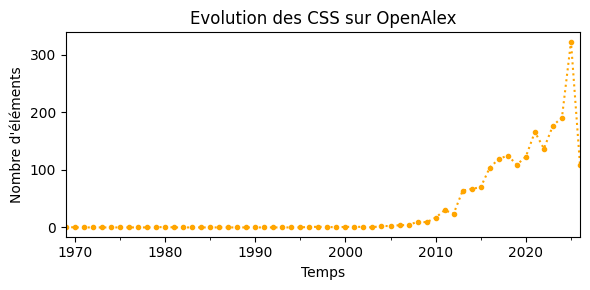

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,3))
df.resample("YE")["id"].count().plot(ax = ax, style=".:", color = "orange")
plt.title("Evolution des CSS sur OpenAlex")
plt.ylabel("Nombre d'éléments")
plt.xlabel("Temps");
plt.tight_layout()
plt.savefig("fig.png")

In [88]:
# df["abstract"]